In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# gervasio file_path
file_path = r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare"


# Temperature

In [32]:
import pandas as pd
import requests

def fetch_hourly_temperature(start_date, end_date, latitude=51.5074, longitude=-0.1278):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": "temperature_2m",
        "timezone": "Europe/London"
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    df = pd.DataFrame({
        "time": pd.to_datetime(data['hourly']['time']),
        "temperature": data['hourly']['temperature_2m']
    })
    return df

# Download data for the full treatment and pre-treatment periods
df_temp = fetch_hourly_temperature("2023-01-01", "2024-12-31")
df_temp.to_csv("london_hourly_temperature_2023_2024.csv", index=False)


In [33]:
df_temp

,time,temperature
0,2023-01-01 00:00:00,12.1
1,2023-01-01 01:00:00,11.3
2,2023-01-01 02:00:00,12.0
3,2023-01-01 03:00:00,11.1
4,2023-01-01 04:00:00,10.5
...,...,...
17539,2024-12-31 19:00:00,10.7
17540,2024-12-31 20:00:00,10.9
17541,2024-12-31 21:00:00,10.9
17542,2024-12-31 22:00:00,10.8


In [42]:
df_weather = df_temp

#df_weather['Timestamp'] = pd.to_datetime(df_weather['time'])
df_weather['Hour'] = df_weather['time'].dt.hour
df_weather['Date'] = df_weather['time'].dt.date
df_weather.head()

# 1. Filter to 4–7pm only
df_temp_peak = df_weather[df_weather['Hour'].between(16, 18)].copy()

# 2. Daily average for those hours
df_temp_daily = df_temp_peak.groupby(df_temp_peak['time'].dt.date)['temperature'].mean().reset_index()
df_temp_daily.columns = ['Date', 'Temp_4to7_avg']
df_temp_daily.head()

,Date,Temp_4to7_avg
0,2023-01-01,10.400000
1,2023-01-02,4.900000
2,2023-01-03,10.566667
3,2023-01-04,12.066667
4,2023-01-05,11.600000


# Electricity

In [50]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path(r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare")

# ----------------------------- #
#  (1)  Helpers
# ----------------------------- #
def load_half_hour_csv(fname: str) -> pd.DataFrame:
    """Read wide half‑hour file → long panel with datetime."""
    df = (pd.read_csv(DATA_DIR / fname)
            .rename(columns={'Unnamed: 0': 'Time'}))
    df['Time'] = pd.to_datetime(df['Time'])
    return df.melt(id_vars='Time',
                   var_name='ANON_ID',
                   value_name='ELEC_KWH')

def tag_window(df, start, end, treat, post_flag):
    """Restrict to [start,end] & add treatment/post dummies."""
    mask = (df['Time'].between(start, end))
    out  = df.loc[mask].copy()
    out['Treatment'] = treat
    out['Post']      = post_flag
    return out

# ----------------------------- #
#  (2)  Load   PRE  (Feb‑23 → Jan‑24)
# ----------------------------- #
pre_rng   = ('2023-04-01', '2023-12-31 23:59:59')
df_pre_ctl = tag_window(load_half_hour_csv("controlePreConsolide.csv"),
                        *pre_rng, treat=0, post_flag=0)
df_pre_trt = tag_window(load_half_hour_csv("interventionPreConsolide.csv"),
                        *pre_rng, treat=1, post_flag=0)
df_pre = pd.concat([df_pre_ctl, df_pre_trt], ignore_index=True)

# ----------------------------- #
#  (3)  Load   POST  (Apr‑24 → Dec‑24)
# ----------------------------- #
post_rng  = ('2024-04-01', '2024-12-31 23:59:59')
df_post_ctl = tag_window(load_half_hour_csv("controleConsolide.csv"),
                         *post_rng, treat=0, post_flag=1)
df_post_trt = tag_window(load_half_hour_csv("interventionConsolide.csv"),
                         *post_rng, treat=1, post_flag=1)
df_post = pd.concat([df_post_ctl, df_post_trt], ignore_index=True)

# ----------------------------- #
#  (4)  Keep only HHs present in **both** periods
# ----------------------------- #
common_ids  = set(df_pre['ANON_ID']).intersection(df_post['ANON_ID'])
df_all = pd.concat([df_pre, df_post], ignore_index=True)
df_all = df_all[df_all['ANON_ID'].isin(common_ids)].reset_index(drop=True)

# ----------------------------- #
#  (5)  Event‑time month index
# ----------------------------- #
df_all['event_month'] = (
    (df_all['Time'].dt.to_period('M')
      .dt.to_timestamp('M')            # last day of month
      - pd.Timestamp('2024-04-30'))    # 0 = April‑24
      .dt.days // 30                   # rough month diff
)

# ----------------------------- #
#  (6)  4‑7 pm peak mean kWh
# ----------------------------- #
peak = df_all[df_all['Time'].dt.hour.between(16,18)]
peak = (peak
        .groupby(['ANON_ID','event_month','Treatment','Post'], as_index=False)
        .agg(peak_kwh=('ELEC_KWH','mean'))
        .sort_values(['ANON_ID','event_month']))

peak.to_parquet("panel_peak_kwh.parquet")
print(peak.head())


                                             ANON_ID  event_month  Treatment  \
0  0045034694b28ba56978092fc4dd601c58774fd74c30b7...          -13          1   
1  0045034694b28ba56978092fc4dd601c58774fd74c30b7...          -12          1   
2  0045034694b28ba56978092fc4dd601c58774fd74c30b7...          -11          1   
3  0045034694b28ba56978092fc4dd601c58774fd74c30b7...          -10          1   
4  0045034694b28ba56978092fc4dd601c58774fd74c30b7...           -9          1   

   Post  peak_kwh  
0     0  0.230200  
1     0  0.148113  
2     0  0.080061  
3     0  0.048425  
4     0  0.025565  


In [51]:
# Step 1: Use your `df_all` (filtered to common ANON_IDs, includes Pre & Post)
df_all['Date'] = df_all['Time'].dt.date
df_all['Hour'] = df_all['Time'].dt.hour

# Step 2: Keep 4–7pm
df_peak_all = df_all[df_all['Hour'].between(16, 18)].copy()

# Step 3: Group by Date & ANON_ID
df_peak_agg = (
    df_peak_all.groupby(['Date', 'ANON_ID', 'Treatment', 'Post'], as_index=False)
    .agg(peak_kwh=('ELEC_KWH', 'mean'))
)

# Step 4: Merge with temperature
df_peak_merged = pd.merge(df_peak_agg, df_temp_daily, on='Date', how='left')
df_peak_merged['Month'] = pd.to_datetime(df_peak_merged['Date']).dt.month
df_peak_merged['Year'] = pd.to_datetime(df_peak_merged['Date']).dt.year


# Dynamic Difference-in-Differences (DiD) 

### analysis using the rich panel df_peak_merged, which includes:

Average consumption during 4–7pm (peak_kwh)

Month & year

Treatment group indicator

Post-treatment period indicator

Daily temperature during the same period

In [52]:
df_peak_merged

,Date,ANON_ID,Treatment,Post,peak_kwh,Temp_4to7_avg,Month,Year
0,2023-04-01,0045034694b28ba56978092fc4dd601c58774fd74c30b7...,1,0,0.383500,11.333333,4,2023
1,2023-04-01,012165987fecd15e61c9a0904c3de15ff6890d4ad579bd...,1,0,0.217167,11.333333,4,2023
2,2023-04-01,018e0c5cf686da1b7ac2d170d54aba9263fdc420b65ff5...,0,0,0.170333,11.333333,4,2023
3,2023-04-01,01b422497e7deb1a7c0ad65e11faabdd20dc9da6a4e520...,0,0,0.217333,11.333333,4,2023
4,2023-04-01,01c05e36af0caaf19d6c35e0340d015ab07e742aa14fda...,1,0,0.155167,11.333333,4,2023
...,...,...,...,...,...,...,...,...
358323,2024-12-31,fd78d9fb0a9035c6a9fe2704c7dcbca1b9add8ea63bf0e...,0,1,0.473333,10.866667,12,2024
358324,2024-12-31,fdc1d55fb1deb8e2575ca3d10cd4ee0c02a6cff74e82b6...,1,1,0.121167,10.866667,12,2024
358325,2024-12-31,fef90b0143496f6e158ba9db416049340d590648659fc6...,0,1,1.085500,10.866667,12,2024
358326,2024-12-31,ffba8412c38b3152abbf790a602f70ccea9313ab717d42...,1,1,0.105500,10.866667,12,2024


In [60]:
import pandas as pd
import statsmodels.formula.api as smf

# Ensure no missing values and correct alignment
df_peak_merged = df_peak_merged.dropna(subset=['peak_kwh', 'Temp_4to7_avg', 'ANON_ID'])

# Make sure ANON_ID is of a proper type
df_peak_merged['ANON_ID'] = df_peak_merged['ANON_ID'].astype(str)


# Make sure these are categorical
df_peak_merged['Month'] = df_peak_merged['Month'].astype(str)  # easier for formula
df_peak_merged['Treatment'] = df_peak_merged['Treatment'].astype(int)
df_peak_merged['Post'] = df_peak_merged['Post'].astype(int)


# ---------------------------
# Dynamic DiD formula:
# ---------------------------
# Base: peak_kwh ~ Treatment + Post + C(Month) + Treatment×Post×C(Month) + Temp
# We interact Post × Treatment × Month (which includes all relevant pairwise interactions)

formula = (
    "peak_kwh ~ C(Month) + Treatment + Post + Temp_4to7_avg "
    "+ Post:C(Month) + Treatment:Post:C(Month)"
)

# Run the regression
model = smf.ols(formula=formula, data=df_peak_merged).fit(cov_type='cluster', cov_kwds={'groups': df_peak_merged['ANON_ID']})

# ---------------------------
# View Summary
# ---------------------------
print(model.summary())

# Extract dynamic DiD coefficients only
dynamic_terms = model.params[model.params.index.str.contains('Treatment:Post:C\(Month\)')]
print("\n📈 Estimated Monthly Treatment Effects (Dynamic DiD):")
print(dynamic_terms)


<>:40: SyntaxWarning: invalid escape sequence '\('
<>:40: SyntaxWarning: invalid escape sequence '\('
C:\Users\gerva\AppData\Local\Temp\ipykernel_12092\2259018562.py:40: SyntaxWarning: invalid escape sequence '\('
  dynamic_terms = model.params[model.params.index.str.contains('Treatment:Post:C\(Month\)')]


                            OLS Regression Results                            
Dep. Variable:               peak_kwh   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     29.76
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          1.93e-102
Time:                        12:57:53   Log-Likelihood:                 61838.
No. Observations:              345196   AIC:                        -1.236e+05
Df Residuals:                  345166   BIC:                        -1.233e+05
Df Model:                          29                                         
Covariance Type:              cluster                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

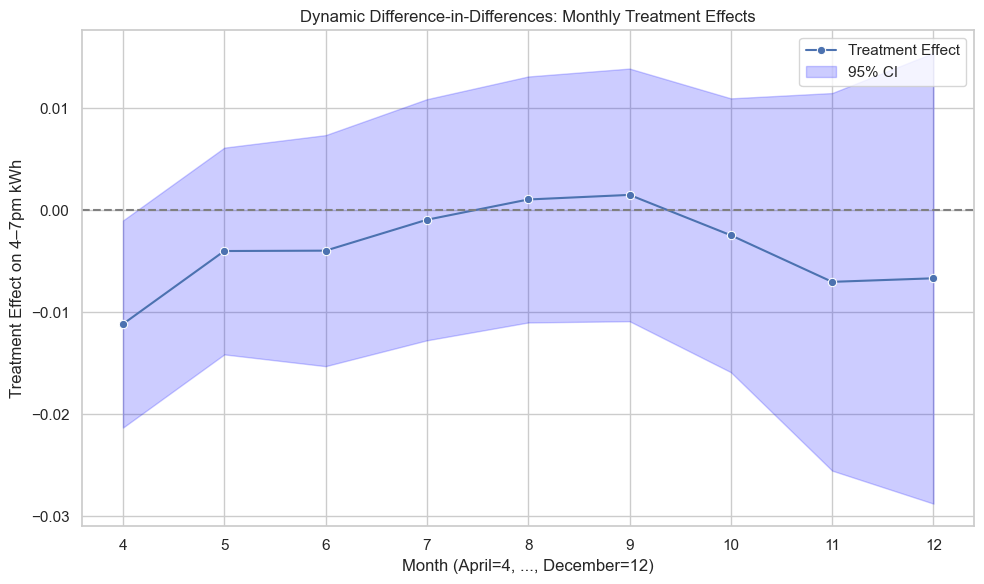

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract Treatment × Post × Month coefficients
dynamic_did = model.params[model.params.index.str.contains("Treatment:Post:C\\(Month\\)")]
dynamic_did_se = model.bse[dynamic_did.index]

# 2. Clean extracted month keys
months = dynamic_did.index.str.extract(r'\[(\d+)\]')[0].dropna().astype(int)

# 3. Build dataframe for plotting
effect_df = pd.DataFrame({
    'Month': months,
    'Effect': dynamic_did.values,
    'SE': dynamic_did_se.values
})
effect_df = effect_df.sort_values('Month')
effect_df['CI_lower'] = effect_df['Effect'] - 1.96 * effect_df['SE']
effect_df['CI_upper'] = effect_df['Effect'] + 1.96 * effect_df['SE']

# 4. Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=effect_df, x='Month', y='Effect', marker='o', label='Treatment Effect')
plt.fill_between(effect_df['Month'], effect_df['CI_lower'], effect_df['CI_upper'],
                 alpha=0.2, color='blue', label='95% CI')

plt.axhline(0, linestyle='--', color='gray')
plt.title("Dynamic Difference-in-Differences: Monthly Treatment Effects")
plt.xlabel("Month (April=4, ..., December=12)")
plt.ylabel("Treatment Effect on 4–7pm kWh")
plt.xticks(ticks=range(4, 13))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Bring Heterogeneous Effects

In [134]:
df_check = df_model[['Pre', 'Post', 'Delta']].copy()
df_check.head()

,Pre,Post,Delta
0,0.221627,0.258379,0.036753
1,0.197656,0.194527,-0.003128
2,0.291909,0.272890,-0.019020
3,0.081028,0.075311,-0.005718
4,0.341487,0.286148,-0.055339


In [139]:
df_check = df_model[['Pre', 'Post', 'Delta']].copy(3)
df_check['manual_delta'] = df_check['Post'] - df_check['Pre']
df_check['check'] = df_check['manual_delta'] == df_check['Delta']

print("All good?", df_check['check'].all())
print("Mismatched rows:", (~df_check['check']).sum())


All good? False
Mismatched rows: 549


In [69]:
# Step 0.2 (unchanged)
import pandas as pd
import os


socio_df = df_merged_with_clusters

# Drop rows where any feature is missing (NaN)
socio_df.dropna(inplace=True)

# Remove 'Unknown'
features = [
    'AGE_GROUP', 'INCOME_CATEGORY', 'CHILDREN_AT_HOME',
    'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
    'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'SOCIAL_GRADE',
    'HOME_VALUE'
]

features = [
    'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY', 'CHILDREN_AT_HOME',
    'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS', 'OCCUPATION', 'EMPLOYMENT_STATUS',
    'HIGHEST_QUALIFICATION', 'HOME_OWNERSHIP', 'HOME_TYPE', 'SOCIAL_GRADE',
    'TARIFF_GROUP', 'HOME_VALUE'
]
mask_no_unknown = (socio_df[features] != 'Unknown').all(axis=1)
socio_df = socio_df[mask_no_unknown].copy()

print(f"Socio-economic data shape after cleaning: {socio_df.shape}")

# Convert columns with a logical order into ordered categories
age_group_order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
income_category_order = [
    '0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999', 
    '40,000-49,999', '50,000-74,999', '75,000-99,999', '100,000+'
] # ordinal
household_occupancy_order = ['Single Adult Household', 'Couple Household', 'Multi-Occupancy Household']
children_at_home_order = ['0', '1', '2+'] # ordinal
household_size_order = ['1', '2', '3-4', '5+'] # ordinal
number_of_bedrooms_order = ['1', '2', '3', '4', '5+'] # ordinal
highest_qualification_order = [
    'GCSE Equivalent', 'A Level Equivalent', 
    'Secondary Education or Less', 'University Degree or Higher'
] # ordinal
home_value_order = ['0-100k', '100-150k', '150-250k', '250-500k', '500k+'] # ordinal
social_grade_order = ['Social grade A', 'Social grade B', 'Social grade C1', 'Social grade C2', 'Social grade D'] # ordinal 

feature_orders = {
    'AGE_GROUP': age_group_order,
    'INCOME_CATEGORY': income_category_order,
    'HOUSEHOLD_OCCUPANCY': household_occupancy_order,
    'CHILDREN_AT_HOME': children_at_home_order,
    'HOUSEHOLD_SIZE': household_size_order,
    'NUMBER_OF_BEDROOMS': number_of_bedrooms_order,
    'HIGHEST_QUALIFICATION': highest_qualification_order,
    'HOME_VALUE': home_value_order,
    'SOCIAL_GRADE': social_grade_order
}
for col, cat_order in feature_orders.items():
    if col in socio_df.columns:
        socio_df[col] = pd.Categorical(socio_df[col], categories=cat_order, ordered=True)


Socio-economic data shape after cleaning: (615, 21)


In [74]:
# Convert ordered categories into numerical codes
for col in feature_orders:
    if col in socio_df.columns:
        socio_df[f"{col}_num"] = socio_df[col].cat.codes

print(socio_df.shape)

socio_df.head()

# Merge numeric socioeconomic data into main df
df_model = socio_df


(615, 30)


In [63]:
from statsmodels.formula.api import ols

model = ols("Delta ~ Group * C(Cluster)", data=df_merged_with_clusters).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Delta   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.031
Date:                Wed, 23 Apr 2025   Prob (F-statistic):             0.0118
Time:                        13:18:20   Log-Likelihood:                 865.04
No. Observations:                 615   AIC:                            -1698.
Df Residuals:                     599   BIC:                            -1627.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

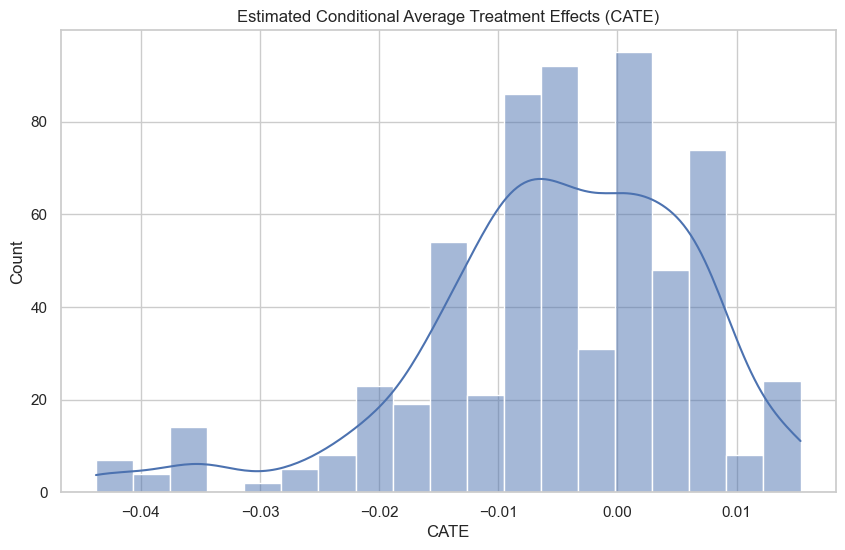

-0.005080905037053394


In [124]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

 

features_causal = {
    'CHILDREN_AT_HOME': children_at_home_order,
    'INCOME_CATEGORY': income_category_order
}
# Inputs
# Define X, T, and Y
X_cols = [f"{col}_num" for col in features_causal] + ['Cluster']  # add 'Cluster' or any other numeric variable
X = df_model[X_cols]
T = df_model['Group']  # 1 = treated, 0 = control
Y = df_model['Delta']  # outcome variable


model_y = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_t = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

cf = CausalForestDML(model_y=model_y, model_t=model_t, random_state=42)
cf.fit(Y, T, X=X)
avgTE = cf.ate(X)


# Estimate Conditional Average Treatment Effects
df_model['CATE'] = cf.effect(X)

# Optional: Visualize distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df_model['CATE'], kde=True)
plt.title("Estimated Conditional Average Treatment Effects (CATE)")
plt.xlabel("CATE")
plt.ylabel("Count")
plt.grid(True)
plt.show()

print(avgTE)

In [123]:
df_cate = df_model.groupby('Cluster')['CATE'].mean().sort_values()
print(df_cate)
# When there are many features, 

Cluster
0.0   -0.031127
6.0   -0.007583
4.0   -0.006136
7.0   -0.005967
1.0   -0.003016
3.0   -0.002131
5.0   -0.000793
2.0    0.001024
Name: CATE, dtype: float64


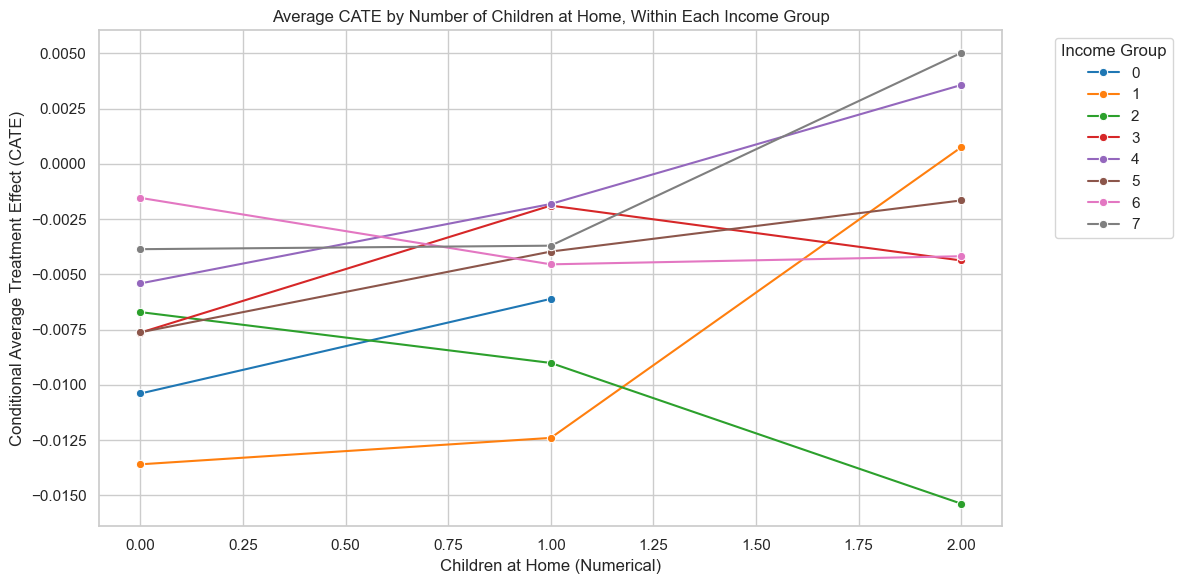

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Group by Income and Children count, compute average CATE
df_cate_by_income = (
    df_model
    .groupby(['INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num'])['CATE']
    .mean()
    .reset_index()
)

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_cate_by_income,
    x='CHILDREN_AT_HOME_num',
    y='CATE',
    hue='INCOME_CATEGORY_num',
    marker='o',
    palette='tab10'
)

# Labels and styling
plt.title("Average CATE by Number of Children at Home, Within Each Income Group")
plt.xlabel("Children at Home (Numerical)")
plt.ylabel("Conditional Average Treatment Effect (CATE)")
plt.grid(True)
plt.legend(title="Income Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


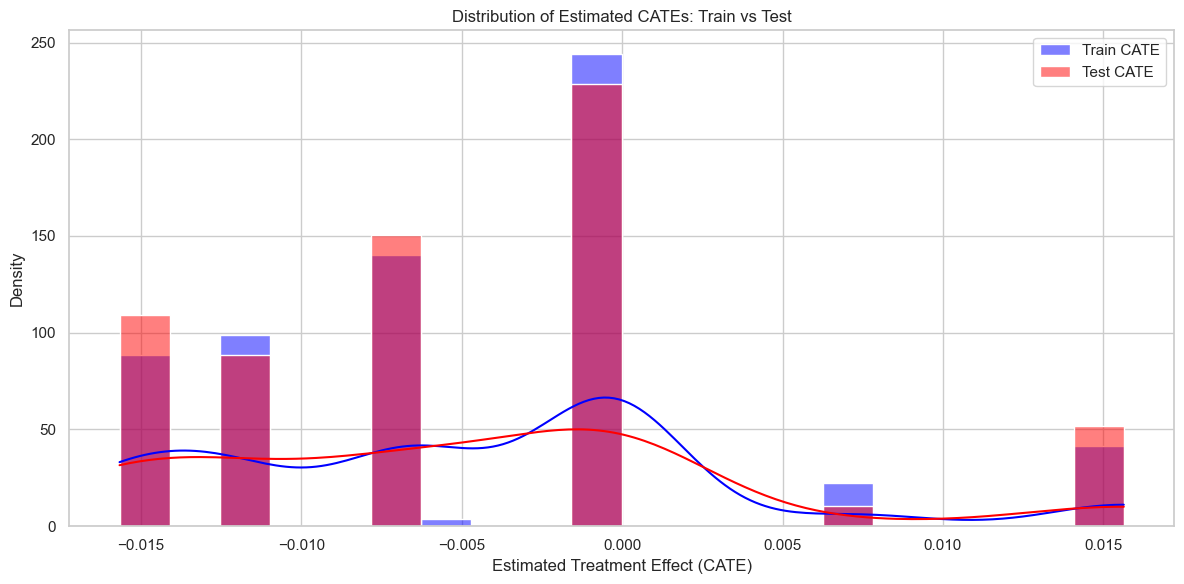

In [216]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from econml.dml import CausalForestDML
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Define Variables
#features = ['INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num', 'Cluster']
features = ['Cluster']
X = df_model[features]
T = df_model['Group']
Y = df_model['Delta']

# 2. Train/Test Split
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=42
)
'''
# 3. Fit Causal Forest on Train
model_y = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_t = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
cf = CausalForestDML(model_y=model_y, model_t=model_t, random_state=42)

'''
model_y = RandomForestRegressor(n_estimators=500, min_samples_leaf=5)

# model T -> uses features to predict the treatment T
model_t = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)


cf = CausalForestDML(
    model_y=model_y,           # see above
    model_t=model_t,           # see above 
    n_estimators=500,          # Number of trees in the forest
    max_depth=10,              # Max depth of each tree
    min_samples_leaf=5,        # Min samples required in a leaf
    max_samples=0.5,           # Fraction of samples to use for each tree
    discrete_treatment=True,   # Binary treatment
    cv=5,                      # 5-fold cross-fitting
    honest=True,               # 'honest' splitting separates data used for node splitting and treatment effect measurement
    criterion='mse',           # splitting criterion maximises heterogeneity score; could also use 'mse'
    random_state=1
)

cf.fit(Y_train, T_train, X=X_train)
# 4. Estimate CATE on both sets
cate_train = cf.effect(X_train)
cate_test = cf.effect(X_test)

# 5. Plot Distributions
plt.figure(figsize=(12, 6))
sns.histplot(cate_train, color='blue', label='Train CATE', kde=True, stat="density",bins=20)
sns.histplot(cate_test, color='red', label='Test CATE', kde=True, stat="density",bins=20)
plt.title("Distribution of Estimated CATEs: Train vs Test")
plt.xlabel("Estimated Treatment Effect (CATE)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim()
plt.show()

# 6. Add to dataframe for downstream use (optional)
df_model_train = X_train.copy()
df_model_test = X_test.copy()
df_model_train['CATE'] = cate_train
df_model_test['CATE'] = cate_test


# achieved X MSE (treatment effect) using CF only socio features
# now i added this clusters, do we improve?


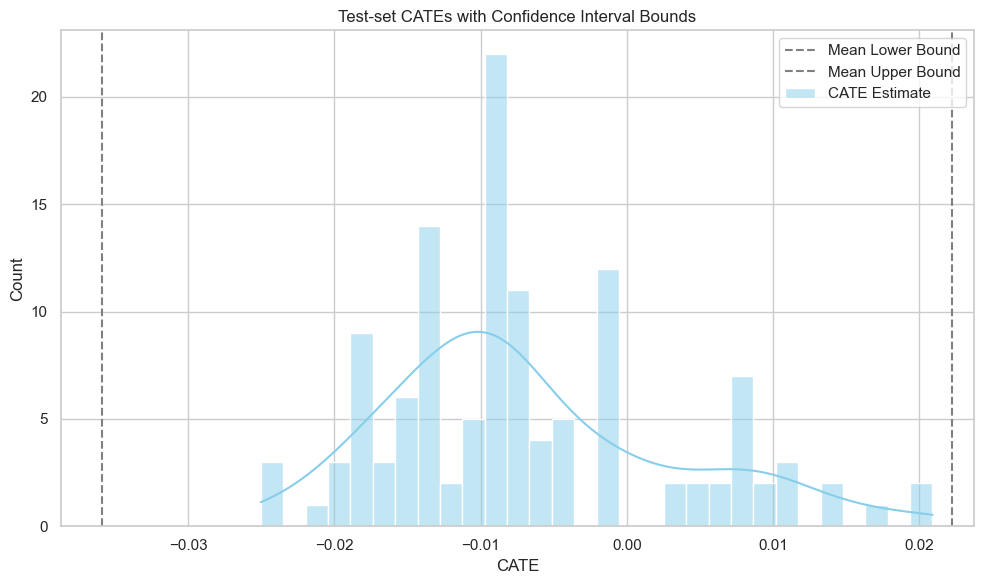

In [153]:
# 1.1 Confidence Intervals on CATE for Test Set
intervals_test = cf.effect_interval(X_test)
lower_bound, upper_bound = intervals_test

# 1.2 Add to test dataframe
df_model_test['CATE_lower'] = lower_bound
df_model_test['CATE_upper'] = upper_bound

# 1.3 Plot CATEs with Confidence Intervals
plt.figure(figsize=(10, 6))
sns.histplot(df_model_test['CATE'], bins=30, kde=True, color='skyblue', label='CATE Estimate')
plt.axvline(x=df_model_test['CATE_lower'].mean(), color='gray', linestyle='--', label='Mean Lower Bound')
plt.axvline(x=df_model_test['CATE_upper'].mean(), color='gray', linestyle='--', label='Mean Upper Bound')
plt.title("Test-set CATEs with Confidence Interval Bounds")
plt.xlabel("CATE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [156]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Predicted treatment effect (CATE) × actual treatment assignment
X_r = T_test.values.reshape(-1, 1) * cate_test.reshape(-1, 1)

# Fit a linear model to predict outcome Y using estimated treatment effects
lr = LinearRegression()
lr.fit(X_r, Y_test)

# Predict Y using this linear model
Y_pred = lr.predict(X_r)

# R² for how much of the outcome is explained by CATEs
r2 = r2_score(Y_test, Y_pred)
print(f"R² (Y ~ CATE * T): {r2:.4f}")


R² (Y ~ CATE * T): 0.0000


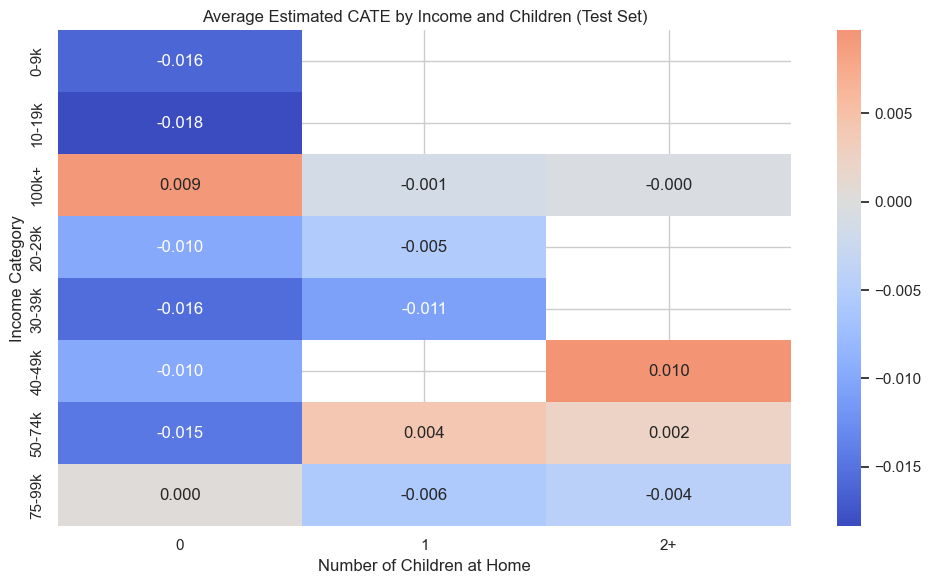

In [159]:
# 3.1 Map categorical labels back (optional for readability)
income_map = {
    0: '0-9k', 1: '10-19k', 2: '20-29k', 3: '30-39k',
    4: '40-49k', 5: '50-74k', 6: '75-99k', 7: '100k+'
}
children_map = {0: '0', 1: '1', 2: '2+'}

df_model_test['Income'] = df_model_test['INCOME_CATEGORY_num'].map(income_map)
df_model_test['Children'] = df_model_test['CHILDREN_AT_HOME_num'].map(children_map)

# 3.2 Grouped Summary
summary = df_model_test.groupby(['Income', 'Children'])['CATE'].agg(['mean', 'count']).reset_index()

# 3.3 Heatmap
pivot = df_model_test.pivot_table(index='Income', columns='Children', values='CATE', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='coolwarm', center=0)
plt.title("Average Estimated CATE by Income and Children (Test Set)")
plt.ylabel("Income Category")
plt.xlabel("Number of Children at Home")
plt.tight_layout()
plt.show()


# Complete Model

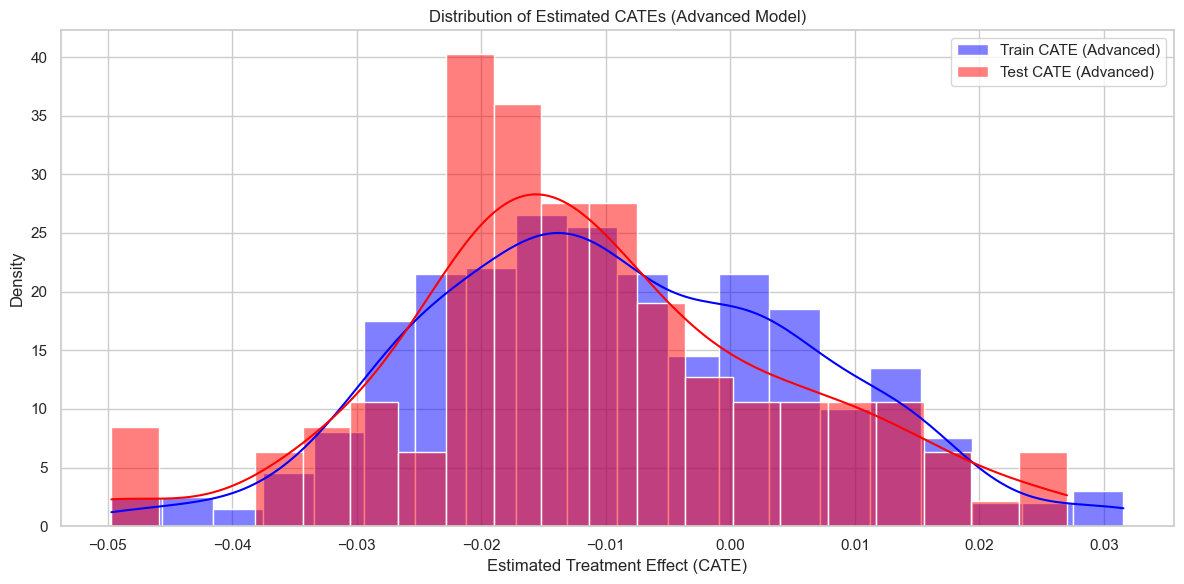

In [218]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt
import seaborn as sns

# One-hot encode AGE_GROUP
df_model_encoded = pd.get_dummies(df_model, columns=['AGE_GROUP'], drop_first=True)
feature_cols_advanced = [
    'INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num',
    'HOUSEHOLD_SIZE_num', 'NUMBER_OF_BEDROOMS_num', 
    'HIGHEST_QUALIFICATION_num',  'SOCIAL_GRADE_num',
    'HOME_VALUE_num'
]

# Define features
#feature_cols_advanced = ['INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num', 'Cluster']
age_cols = [col for col in df_model_encoded.columns if col.startswith('AGE_GROUP_')]
X_advanced = df_model_encoded[feature_cols_advanced + age_cols] 
T_advanced = df_model_encoded['Group']
Y_advanced = df_model_encoded['Delta']

# Split
X_train_adv, X_test_adv, T_train_adv, T_test_adv, Y_train_adv, Y_test_adv = train_test_split(
    X_advanced, T_advanced, Y_advanced, test_size=0.2, random_state=42
)

# Causal Forest setup
model_y_adv = RandomForestRegressor(n_estimators=500, min_samples_leaf=5)
model_t_adv = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)

cf_advanced = CausalForestDML(
    model_y=model_y_adv,
    model_t=model_t_adv,
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=5,
    max_samples=0.5,
    discrete_treatment=True,
    cv=5,
    honest=True,
    criterion='mse',
    random_state=1
)

cf_advanced.fit(Y_train_adv, T_train_adv, X=X_train_adv)

# Estimate CATE
cate_train_adv = cf_advanced.effect(X_train_adv)
cate_test_adv = cf_advanced.effect(X_test_adv)

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(cate_train_adv, color='blue', label='Train CATE (Advanced)', kde=True, stat="density", bins=20)
sns.histplot(cate_test_adv, color='red', label='Test CATE (Advanced)', kde=True, stat="density", bins=20)
plt.title("Distribution of Estimated CATEs (Advanced Model)")
plt.xlabel("Estimated Treatment Effect (CATE)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


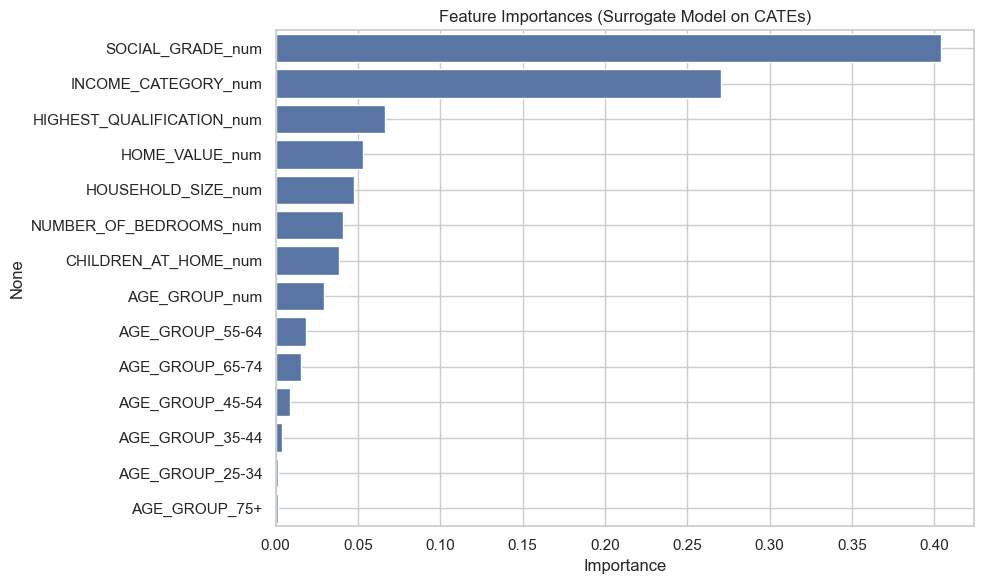

In [215]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Fit surrogate model
surrogate_model = RandomForestRegressor(random_state=42)
surrogate_model.fit(X_train_adv, cate_train_adv)

# Feature importances
importances = surrogate_model.feature_importances_
feat_importances = pd.Series(importances, index=X_train_adv.columns).sort_values(ascending=False)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title("Feature Importances (Surrogate Model on CATEs)")
plt.xlabel("Importance")
plt.tight_layout()
plt.grid(True)
plt.show()


In [177]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict Y using τ̂(X) * T as proxy for treatment contribution
# This is not the same as full outcome prediction but helps understand explanatory power of τ̂
y_hat_test = cate_test_adv * T_test_adv
pseudo_rmse = np.sqrt(mean_squared_error(Y_test_adv, y_hat_test))
print(f"Pseudo RMSE (CATE × T vs. Y): {pseudo_rmse:.4f}")


Pseudo RMSE (CATE × T vs. Y): 0.0451


# Evaluation of models

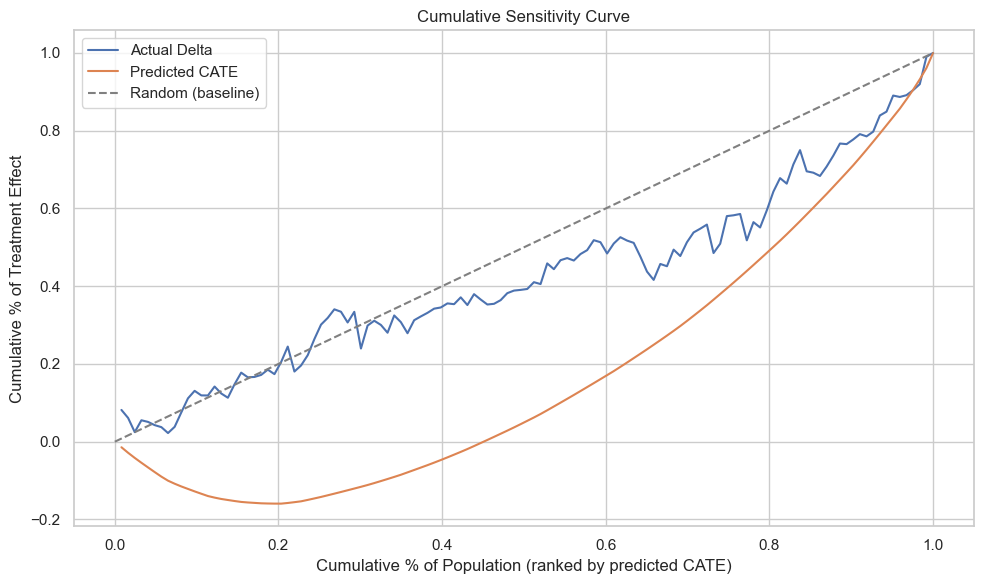

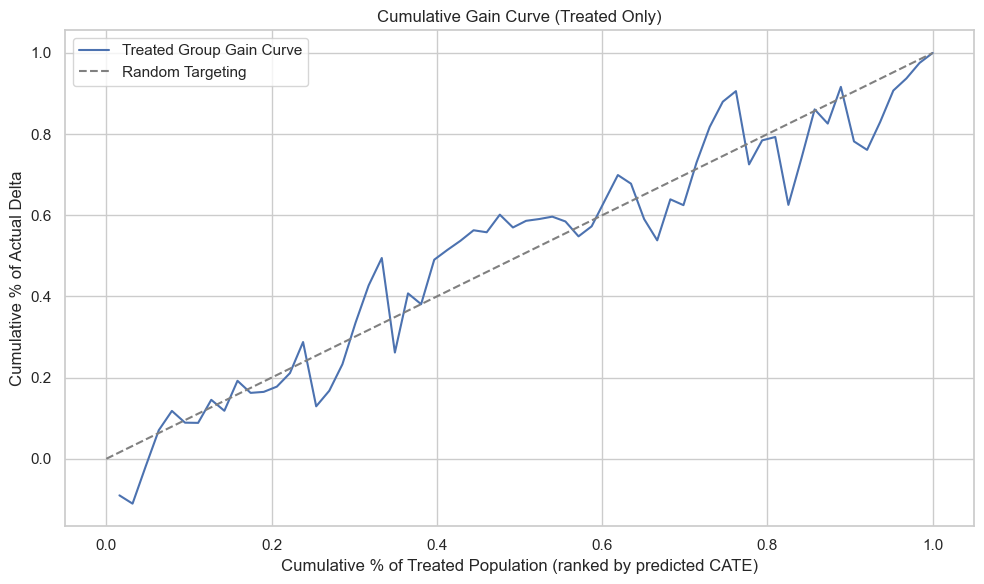

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------
# Combine test set data
# -------------------------------------------
df_eval = X_test_adv.copy()
df_eval['CATE'] = cate_test_adv
df_eval['Delta'] = Y_test_adv
df_eval['Treatment'] = T_test_adv

# -------------------------------------------
# Sort by CATE (descending): households with strongest predicted effect first
# -------------------------------------------
df_sorted = df_eval.sort_values(by='CATE', ascending=False).reset_index(drop=True)
df_sorted['Cumulative_Count'] = np.arange(1, len(df_sorted)+1)

# -------------------------------------------
# Cumulative Sensitivity: sum of actual effects (Delta) across percentiles
# -------------------------------------------
df_sorted['Cumulative_Actual_Effect'] = df_sorted['Delta'].cumsum()
df_sorted['Cumulative_Predicted_Effect'] = df_sorted['CATE'].cumsum()

# Normalize by total sum to get % of effect captured
total_actual = df_sorted['Delta'].sum()
total_pred = df_sorted['CATE'].sum()
df_sorted['%_Actual_Effect'] = df_sorted['Cumulative_Actual_Effect'] / total_actual
df_sorted['%_Predicted_Effect'] = df_sorted['Cumulative_Predicted_Effect'] / total_pred
df_sorted['% Population'] = df_sorted['Cumulative_Count'] / len(df_sorted)

# -------------------------------------------
# PLOT: Cumulative Sensitivity Curve
# -------------------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(x='% Population', y='%_Actual_Effect', data=df_sorted, label='Actual Delta')
sns.lineplot(x='% Population', y='%_Predicted_Effect', data=df_sorted, label='Predicted CATE')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random (baseline)')
plt.xlabel('Cumulative % of Population (ranked by predicted CATE)')
plt.ylabel('Cumulative % of Treatment Effect')
plt.title('Cumulative Sensitivity Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -------------------------------------------
# Cumulative Gain: uplift modeling performance
# -------------------------------------------
df_treated = df_sorted[df_sorted['Treatment'] == 1].copy()
df_control = df_sorted[df_sorted['Treatment'] == 0].copy()

# Rank by CATE in treated group
df_treated = df_treated.sort_values(by='CATE', ascending=False).reset_index(drop=True)
df_treated['Rank'] = np.arange(1, len(df_treated)+1)
df_treated['% Population'] = df_treated['Rank'] / len(df_treated)
df_treated['Cumulative Effect'] = df_treated['Delta'].cumsum()
df_treated['% Cumulative Effect'] = df_treated['Cumulative Effect'] / df_treated['Delta'].sum()

# -------------------------------------------
# PLOT: Cumulative Gain Curve
# -------------------------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(x='% Population', y='% Cumulative Effect', data=df_treated, label='Treated Group Gain Curve')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random Targeting')
plt.xlabel('Cumulative % of Treated Population (ranked by predicted CATE)')
plt.ylabel('Cumulative % of Actual Delta')
plt.title('Cumulative Gain Curve (Treated Only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



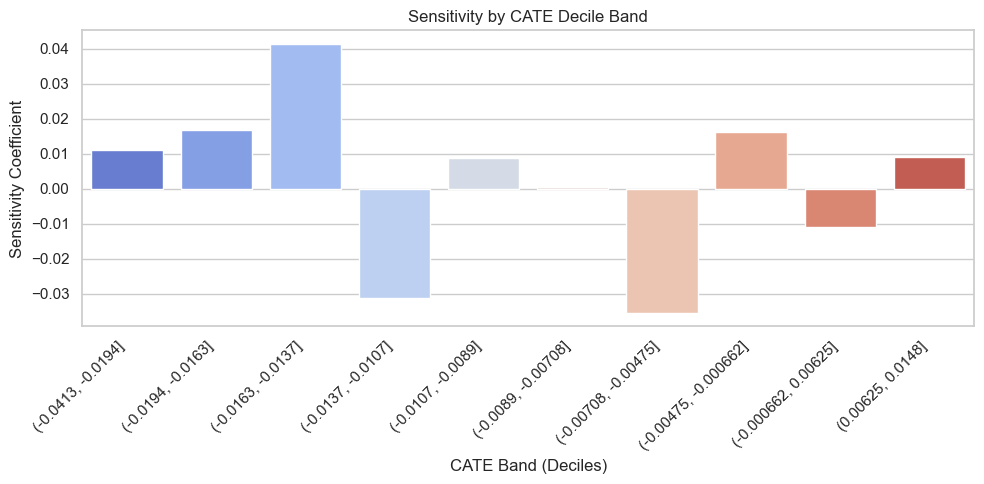

In [195]:
import pandas as pd
import numpy as np
from toolz import curry
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Define Sensitivity Function
# -----------------------------
@curry
def sensitivity(data, y, t):
    return (np.sum((data[t] - data[t].mean()) * (data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))

def sensitivity_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band": pd.qcut(df[pred], q=bands, duplicates='drop')})
            .groupby(f"{pred}_band")
            .apply(sensitivity(y=y, t=t))
            .reset_index(name='Sensitivity'))

# -----------------------------
# 2. Prepare Data
# -----------------------------
df_sens = X_test_adv.copy()
df_sens['CATE'] = cate_test_adv
df_sens['Delta'] = Y_test_adv
df_sens['Treatment'] = T_test_adv

# -----------------------------
# 3. Compute Sensitivity by CATE Band
# -----------------------------
sensitivity_results = sensitivity_by_band(df_sens, pred='CATE', y='Delta', t='Treatment', bands=10)

# -----------------------------
# 4. Plot Sensitivity by CATE Band
# -----------------------------
plt.figure(figsize=(10, 5))
sns.barplot(data=sensitivity_results, x='CATE_band', y='Sensitivity', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Sensitivity by CATE Decile Band')
plt.ylabel('Sensitivity Coefficient')
plt.xlabel('CATE Band (Deciles)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [205]:
# ╭──────────────────────────────────────────────────────────────╮
# │   EVALUATION FUNCTIONS                                       │
# ╰──────────────────────────────────────────────────────────────╯

def cumulative_sensitivity(df, cate_col='CATE', outcome_col='Delta', treatment_col='Treatment'):
    # Sort by CATE descending (i.e., rank people from highest to lowest estimated effect)
    df_sorted = df.sort_values(by=cate_col, ascending=False).copy()
    
    # Initialize lists
    sens_list = []
    frac_list = []
    
    for i in range(1, len(df_sorted)+1):
        # Take top i rows
        sub_df = df_sorted.iloc[:i]
        # Compute sensitivity
        sens = sensitivity(sub_df, y=outcome_col, t=treatment_col)
        sens_list.append(sens)
        frac_list.append(i / len(df_sorted))
    
    return pd.DataFrame({'Fraction': frac_list, 'CumulativeSensitivity': sens_list})

def cumulative_gain(df, prediction='CATE', y='Delta', t='Group', min_periods=30, steps=100):
    size = df.shape[0]
    df_sorted = df.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # Avoid zero step size in range
    step_size = max(1, size // steps)
    n_rows = list(range(min_periods, size, step_size)) + [size]

    return np.array([
        sensitivity(df_sorted.head(rows), y=y, t=t) * (rows / size)
        for rows in n_rows
    ])


def sensitivity_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = sensitivity(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1 * df[t])
    se = np.sqrt(((1 / (n - 2)) * np.sum(e**2)) / np.sum((df[t] - t_bar)**2))
    return np.array([beta1 - z * se, beta1 + z * se])  # ✅ fixed `see` → `se`


def cumulative_sensitivity_curve_ci(df, prediction='CATE', y='Delta', t='Group', min_periods=30, steps=100):
    size = df.shape[0]
    df_sorted = df.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    step_size = max(1, size // steps)
    n_rows = list(range(min_periods, size, step_size)) + [size]

    return np.array([
        sensitivity_ci(df_sorted.head(rows), y=y, t=t)
        for rows in n_rows
    ])




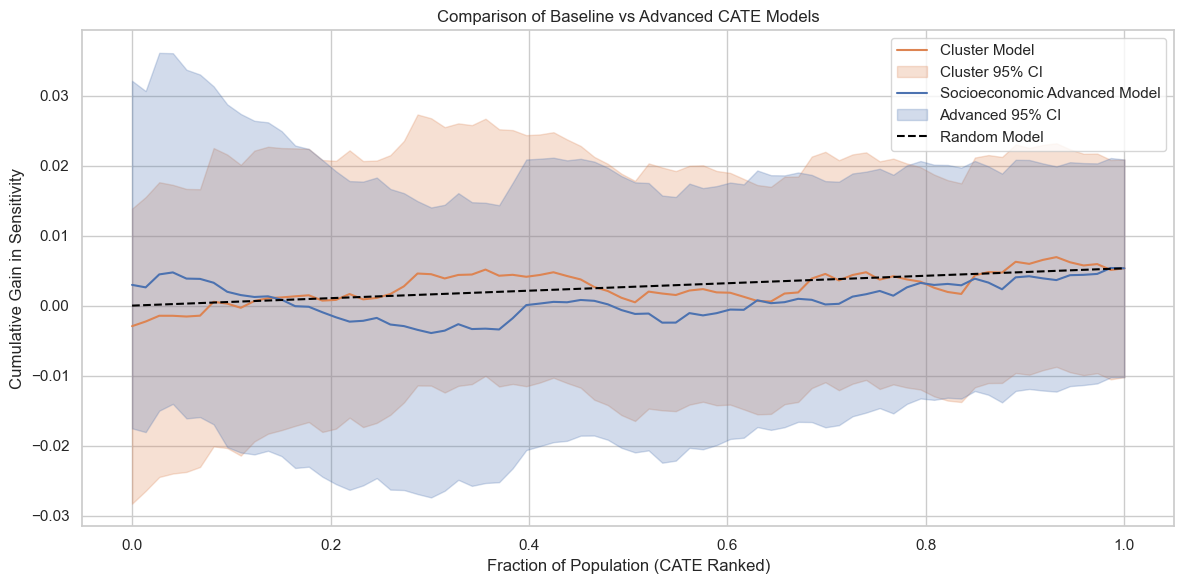

In [220]:
# 1 Create models

# Create baseline test set (if not already)
df_model_test_base = X_test.copy()
df_model_test_base['Group'] = T_test
df_model_test_base['Delta'] = Y_test
df_model_test_base['CATE'] = cate_test  # <- from the baseline model


# Create advanced test set
df_model_test = X_test_adv.copy()
df_model_test['Group'] = T_test_adv
df_model_test['Delta'] = Y_test_adv
df_model_test['CATE'] = cate_test_adv

import numpy as np
import matplotlib.pyplot as plt

# 1. Compute cumulative gain for both models
cum_gain_base = cumulative_gain(df_model_test_base, "CATE", "Delta", "Group", min_periods=50, steps=200)
cum_gain_adv = cumulative_gain(df_model_test, "CATE", "Delta", "Group", min_periods=50, steps=200)

# 2. Compute confidence intervals
cum_gain_ci_base = cumulative_sensitivity_curve_ci(df_model_test_base, "CATE", "Delta", "Group", min_periods=50, steps=200)
cum_gain_ci_adv = cumulative_sensitivity_curve_ci(df_model_test, "CATE", "Delta", "Group", min_periods=50, steps=200)

# 3. Define x-axis (normalized rank)
x_vals = np.linspace(0, 1, len(cum_gain_base))

# 4. Plot
plt.figure(figsize=(12, 6))
plt.plot(x_vals, cum_gain_base, label="Cluster Model", color="C1")
plt.fill_between(x_vals, cum_gain_ci_base[:, 0], cum_gain_ci_base[:, 1], alpha=0.25, color="C1", label="Cluster 95% CI")

plt.plot(x_vals, cum_gain_adv, label="Socioeconomic Advanced Model", color="C0")
plt.fill_between(x_vals, cum_gain_ci_adv[:, 0], cum_gain_ci_adv[:, 1], alpha=0.25, color="C0", label="Advanced 95% CI")

# Reference line
baseline_sens = sensitivity(df_model_test_base, y='Delta', t='Group')
plt.plot([0, 1], [0, baseline_sens], linestyle='--', color='black', label='Random Model')

# Formatting
plt.xlabel("Fraction of Population (CATE Ranked)")
plt.ylabel("Cumulative Gain in Sensitivity")
plt.title("Comparison of Baseline vs Advanced CATE Models")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



### Comparison of Cluster-Only vs Socioeconomic Advanced CATE Models

The plot above displays cumulative gain in sensitivity for two CATE models:
- **Cluster Model (orange)**: This baseline model uses only the counterfactual clusters (derived from energy usage profiles) as features.
- **Socioeconomic Advanced Model (blue)**: This model incorporates selected socioeconomic variables—`INCOME_CATEGORY`, `CHILDREN_AT_HOME`, and others—chosen for their relevance to behavioral energy consumption.

#### Interpretation:

- **Cumulative Gain Curve**: Measures how well the model identifies individuals for whom the treatment (intervention) had the largest effect on consumption. Higher cumulative gain suggests better ranking of treatment effect heterogeneity.
- **Confidence Bands (95%)**: Indicate uncertainty around each model's gain estimate at different fractions of the population.

#### Key Observations:

- The **Cluster Model** shows a slightly higher cumulative gain than the socioeconomic model across most of the population, suggesting that usage-based clusters alone offer meaningful structure for targeting.
- The **Socioeconomic Model** exhibits more stability in the gain curve and less deviation from the random baseline, which may reflect a more conservative ranking of treatment effect heterogeneity.
- Both models outperform the **Random Model** baseline (dashed line), meaning they are learning signal beyond noise.

#### Conclusion:

The cluster-only model provides slightly better targeting performance in terms of treatment effect sensitivity, though its confidence interval overlaps significantly with the socioeconomic model. The socioeconomic model may offer better interpretability and fairness. Depending on program goals (e.g., targeting vs understanding), either could be preferable. Future work could explore **hybrid models** that combine both sets of features for improved performance.


invalid value encountered in scalar divide


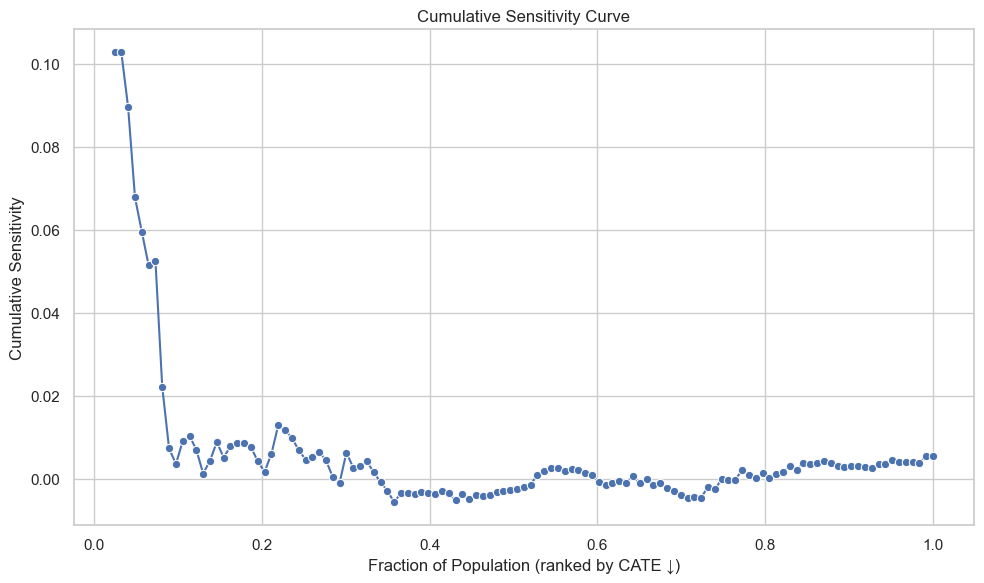

In [197]:
# Compute and Plot
cum_sens_df = cumulative_sensitivity(df_sens, cate_col='CATE', outcome_col='Delta', treatment_col='Treatment')

plt.figure(figsize=(10, 6))
sns.lineplot(data=cum_sens_df, x='Fraction', y='CumulativeSensitivity', marker='o')
plt.title("Cumulative Sensitivity Curve")
plt.xlabel("Fraction of Population (ranked by CATE ↓)")
plt.ylabel("Cumulative Sensitivity")
plt.grid(True)
plt.tight_layout()
plt.show()


R Learner

📊 R-Learner Pseudo RMSE: 0.0470


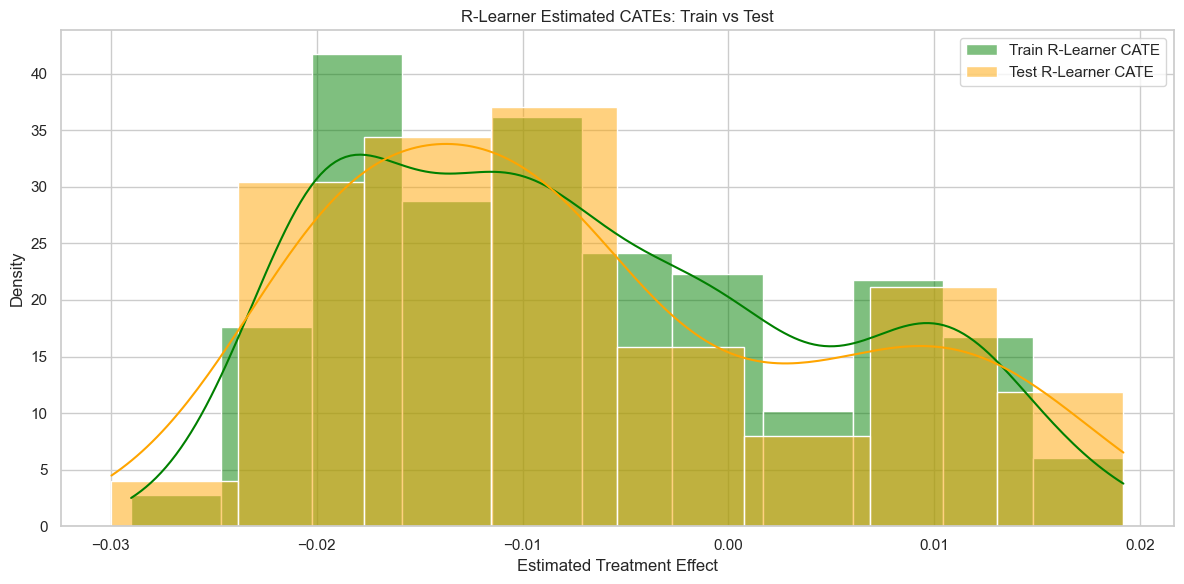

In [170]:
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define Features and Split
features = ['INCOME_CATEGORY_num', 'CHILDREN_AT_HOME_num', 'Cluster']  # Add more if needed
X = df_model[features]
T = df_model['Group']
Y = df_model['Delta']

X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=42
)

# 2. Instantiate and Fit R-Learner using LinearDML
model_y = RandomForestRegressor(n_estimators=100, random_state=42)
model_t = RandomForestClassifier(n_estimators=100, random_state=42)

rlearner = LinearDML(model_y=model_y, model_t=model_t, discrete_treatment=True, random_state=42)
rlearner.fit(Y_train, T_train, X=X_train)

# 3. Predict CATE
cate_r_train = rlearner.effect(X_train)
cate_r_test = rlearner.effect(X_test)

# 4. Pseudo RMSE as diagnostic
rms_rlearner = np.sqrt(np.mean((T_test * cate_r_test - Y_test) ** 2))
print(f"📊 R-Learner Pseudo RMSE: {rms_rlearner:.4f}")

# 5. Visualization
plt.figure(figsize=(12, 6))
sns.histplot(cate_r_train, color='green', label='Train R-Learner CATE', kde=True, stat="density")
sns.histplot(cate_r_test, color='orange', label='Test R-Learner CATE', kde=True, stat="density")
plt.title("R-Learner Estimated CATEs: Train vs Test")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [185]:
df_model_test['CATE'] = cate_test
grouped = df_model_test.groupby('Cluster')['CATE'].agg(['mean', 'std', 'count'])
print(grouped.sort_values('mean'))


             mean       std  count
Cluster                           
0.0     -0.014452  0.004082     11
4.0     -0.013380  0.016475     17
7.0     -0.012171  0.005576     21
3.0     -0.006217  0.001973      2
1.0     -0.004773  0.007389     18
5.0     -0.003496  0.009028     44
2.0      0.003232  0.005911     10


<Axes: xlabel='INCOME_CATEGORY_num', ylabel='CATE'>

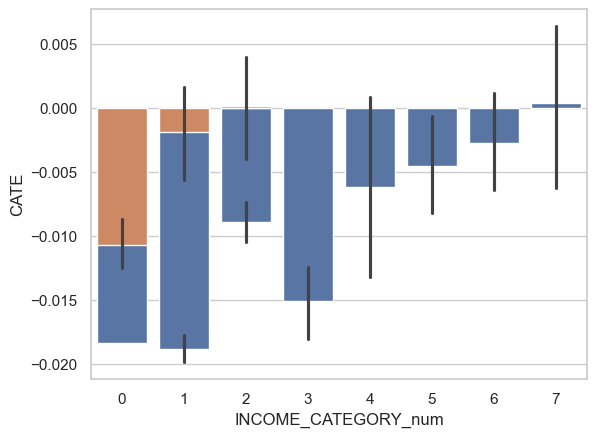

In [186]:
sns.barplot(data=df_model_test, x='INCOME_CATEGORY_num', y='CATE')
sns.barplot(data=df_model_test, x='CHILDREN_AT_HOME_num', y='CATE')


# WEB EXAMPLE

In [85]:
# Use "pip install econml" on the command line to install the package
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from econml.orf import DMLOrthoForest as CausalForest

df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Crime.csv')

# Set the categorical variables:
cat_vars = ['year', 'region', 'smsa']
# Transform the categorical variables to dummies and add them back in
xf = pd.get_dummies(df[cat_vars])
df = pd.concat([df.drop(cat_vars, axis=1), xf], axis=1)
cat_var_dummy_names = list(xf.columns)

regressors = ['prbarr', 'prbconv', 'prbpris',
              'avgsen', 'polpc', 'density', 'taxpc',
              'pctmin', 'wcon']
# Add in the dummy names to the list of regressors
regressors = regressors + cat_var_dummy_names

# Split into train and test
train, test = train_test_split(df, test_size=0.2)

# Estimate causal forest
estimator = CausalForest(n_trees=100,
                         model_T=DecisionTreeRegressor(),
                         model_Y=DecisionTreeRegressor())
estimator.fit(Y=train['crmrte'],
              T=train['pctymle'],
              W=train[regressors],
              X=train[regressors],
              inference='blb')
effects_train = estimator.effect(train[regressors])
effects_test = estimator.effect(test[regressors])
conf_intrvl = estimator.effect_interval(test[regressors])


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 473 out of 504 | elapsed:   29.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   29.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 126 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    0.9s finished


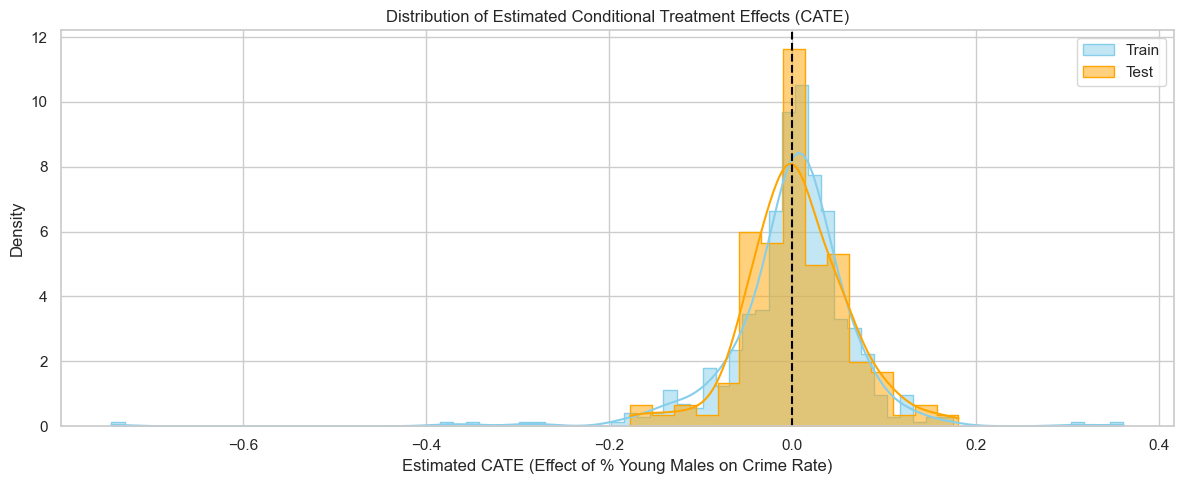

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Histogram of CATEs on train data
sns.histplot(effects_train, kde=True, color='skyblue', label='Train', stat='density', element='step')
sns.histplot(effects_test, kde=True, color='orange', label='Test', stat='density', element='step')

plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel("Estimated CATE (Effect of % Young Males on Crime Rate)")
plt.ylabel("Density")
plt.title("Distribution of Estimated Conditional Treatment Effects (CATE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


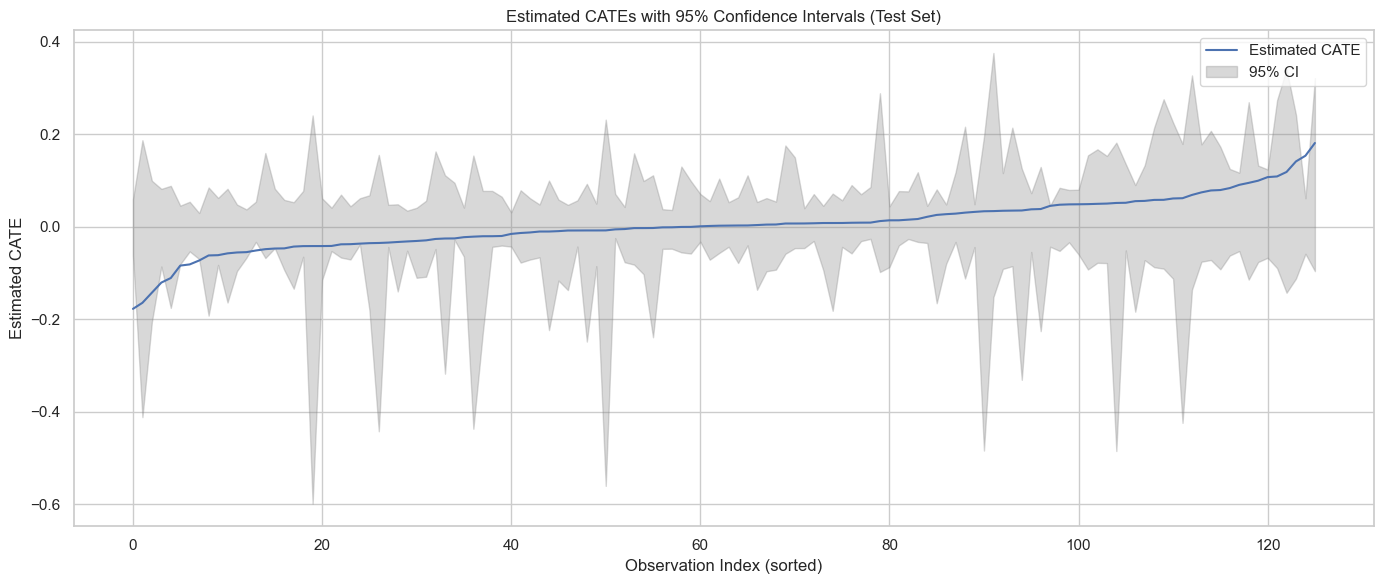

In [87]:
import numpy as np

# Sort for cleaner plotting
idx_sorted = np.argsort(effects_test)
effects_sorted = effects_test[idx_sorted]
lower, upper = conf_intrvl
lower_sorted = lower[idx_sorted]
upper_sorted = upper[idx_sorted]

plt.figure(figsize=(14, 6))
plt.plot(effects_sorted, label='Estimated CATE')
plt.fill_between(np.arange(len(effects_sorted)), lower_sorted, upper_sorted, color='gray', alpha=0.3, label='95% CI')

plt.xlabel("Observation Index (sorted)")
plt.ylabel("Estimated CATE")
plt.title("Estimated CATEs with 95% Confidence Intervals (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [96]:
from sklearn.cluster import KMeans

df_plot = train.copy()
df_plot['CATE'] = effects_train

# Cluster based on CATE only
df_plot['CATE_Cluster'] = KMeans(n_clusters=4, random_state=42).fit_predict(df_plot[['CATE']])

# Now analyze each cluster:
summary = df_plot.groupby('CATE_Cluster')[regressors].mean()
print(summary)


                prbarr   prbconv   prbpris     avgsen     polpc   density  \
CATE_Cluster                                                                
0             0.295506  0.649832  0.428725   8.622961  0.001683  1.484288   
1             0.338339  0.636534  0.415953   8.246034  0.002048  1.650362   
2             0.343895  0.902834  0.414018  10.136667  0.002415  1.054928   
3             0.206897  0.909091  0.366667   8.590000  0.000641  1.030888   

                  taxpc     pctmin         wcon       year  region_central  \
CATE_Cluster                                                                 
0             29.706411  26.048636   240.834894  83.948640        0.404834   
1             44.036306  35.383684   265.441727  84.362069        0.293103   
2             25.744318  19.603752   242.327080  84.043860        0.333333   
3             24.036370   7.916320  2324.598000  85.000000        1.000000   

              region_other  region_west   smsa_no  smsa_yes  
CATE_C

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
